### 1. Library Loading

In [1]:
!pip install pyupbit

In [2]:
!pip install ace_tools

In [22]:
# Windows + Anaconda + numpy + scikit-learn 조합일 경우 os 셋팅 추가
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import requests
import numpy as np
import pandas as pd
import pyupbit as pyu
import re
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. 가상화폐 기본 정보 가져오기

In [7]:
# KRW Market ticker 추출
url_market = "https://api.upbit.com/v1/market/all"
url_ticker = "https://api.upbit.com/v1/ticker"

markets_resp = requests.get(url_market)
markets_data = markets_resp.json()



krw_markets = [market['market'] for market in markets_data if market['market'].startswith('KRW-')]

df_crypto = pd.DataFrame({"market" : [full_ticker.split("-")[0]  for full_ticker in krw_markets],
                          "coin_name" : [full_ticker.split("-")[1]  for full_ticker in krw_markets],
                          "ticker" : krw_markets
                         }
                        )

In [8]:
def parse_market_cap(text):
    # 숫자와 단위를 추출
    word_match = re.search(r'([\d,.]+)([억만조])원', text)
    number = float(word_match.group(1).replace(',', ''))
    unit = word_match.group(2)

    unit_multipliers = {
        '만': 10000,
        '억': 100000000,
        '조': 1000000000000,
    }
    market_cap_numeric = number * unit_multipliers[unit]

    # 날짜를 추출하여 YYYY-MM-DD 형식으로 변환
    date_match = re.search(r'\((\d{2}\.\d{2}\.\d{2})\. 기준\)', text)
    date_str = date_match.group(1)
    date_formatted = datetime.strptime(date_str, '%y.%m.%d').strftime('%Y-%m-%d')

    return market_cap_numeric, date_formatted, unit

In [9]:
for i in range(len(df_crypto)):
    try:
        total_amount = requests.get("https://api-manager.upbit.com/api/v1/coin_info/pub/{}.json".format(df_crypto.coin_name[i])).json()['data']['header_key_values']['market_cap']['value']

        market_cap_numeric, date_formatted, unit = parse_market_cap(total_amount)

        df_crypto.loc[i, "total_amount"] = total_amount
        df_crypto.loc[i, "total_amount_value"] = market_cap_numeric
        df_crypto.loc[i, "unit"] = unit
        df_crypto.loc[i, "reference_date"] = date_formatted
    except Exception as e:
        print(df_crypto.coin_name[i])

SONIC


In [ ]:
# 데이터 저장
# df_crypto.to_excel("crypto_master_data.xlsx")

### 3. 시세 데이터 가져오기

In [10]:
now = datetime.now()
formatted_time = now.strftime("%Y%m%d %H:%M:%S")

df_crypto_ohlcv = pd.DataFrame()

for crypto in df_crypto.ticker.tolist():
    # count : 가져올 기간 수
    # to : 기간 최대 일자
    # period : 데이터 요청 주기 (초)
    try:
        crypto_price = pyu.get_ohlcv(ticker=crypto,
                                    interval='day',
                                    count=365,
                                    to=formatted_time,
                                    period=0.1)
        crypto_price.insert(1, "ticker", crypto)

        # 이동평균 산출
        crypto_price['ma_05'] = crypto_price['close'].rolling(window=5).mean()
        crypto_price['ma_10'] = crypto_price['close'].rolling(window=10).mean()
        crypto_price['ma_20'] = crypto_price['close'].rolling(window=20).mean()
        crypto_price['ma_30'] = crypto_price['close'].rolling(window=30).mean()
        crypto_price['ma_60'] = crypto_price['close'].rolling(window=60).mean()
        crypto_price['ma_120'] = crypto_price['close'].rolling(window=120).mean()
        crypto_price['ma_200'] = crypto_price['close'].rolling(window=200).mean()

        # RSI(Relative Strength Index) 산출
        delta = crypto_price['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        crypto_price['rsi'] = 100 - (100 / (1 + rs))

        # MACD 산출
        ema12 = crypto_price['close'].ewm(span=12, adjust=False).mean()
        ema26 = crypto_price['close'].ewm(span=26, adjust=False).mean()
        crypto_price['macd'] = ema12 - ema26
        crypto_price['signal'] = crypto_price['macd'].ewm(span=9, adjust=False).mean()
        crypto_price['macd_hist'] = crypto_price['macd'] - crypto_price['signal']

        # DMA(Difference of Moving Averages) 산출
        short_ma = crypto_price['close'].rolling(window=10).mean()
        long_ma = crypto_price['close'].rolling(window=50).mean()
        crypto_price['dma'] = short_ma - long_ma

        # 볼린저 밴드 (Bollinger Bands) 산출
        crypto_price['std20'] = crypto_price['close'].rolling(window=20).std()
        crypto_price['Upperbb'] = crypto_price['ma_20'] + (2 * crypto_price['std20'])
        crypto_price['Lowerbb'] = crypto_price['ma_20'] - (2 * crypto_price['std20'])


        df_crypto_ohlcv = pd.concat([df_crypto_ohlcv, crypto_price], axis=0)
    except Exception as e:
        print(crypto)

In [13]:
# 데이터 저장
df_crypto_ohlcv.to_parquet("df_crypto_ohlcv_daily.parquet")
df_crypto_ohlcv.to_csv("df_crypto_ohlcv_daily.csv")

### 4. 데이터 전처리

In [10]:
# # 위의 작업으로 수집해서 저장한 파일을 로딩해서 사용 하는 경우 아래 로직 사용
# file_path = "df_crypto_ohlcv_daily.csv"
# df_crypto_daily = pd.read_csv(file_path)

# # 날짜 처리 및 정렬
# df_crypto_daily['date'] = pd.to_datetime(df_crypto_daily['Unnamed: 0'])
# df_crypto_daily = df_crypto_daily.drop(columns=['Unnamed: 0'])
# df_crypto_daily = df_crypto_daily.sort_values(['ticker', 'date']).reset_index(drop=True)

# # 상승/하락 라벨 생성 (다음날 종가 대비 상승 여부)
# df_crypto_daily['target'] = df_crypto_daily.groupby('ticker')['close'].shift(-1) > df_crypto_daily['close']
# df_crypto_daily['target'] = df_crypto_daily['target'].astype(int)

# # 특징 컬럼 선택 (기술적 지표 기반)
# feature_cols = ['ma_05', 'ma_10', 'ma_20', 'ma_60', 'ma_120', 'ma_200',
#                 'rsi', 'macd', 'signal', 'macd_hist', 'dma', 'std20', 'Upperbb', 'Lowerbb']

# # 결측치 처리
# for col in feature_cols:
#     if 'rsi' in col:
#         # 중립값 처리
#         df_crypto_daily[col] = df_crypto_daily[col].fillna(50)
#     elif 'ma' in col or 'bb' in col or 'std' in col:
#         df_crypto_daily[col] = df_crypto_daily[col].fillna(method='ffill').fillna(method='bfill')
#     else:
#         df_crypto_daily[col] = df_crypto_daily[col].fillna(0)

# X = df_crypto_daily[feature_cols]
# y = df_crypto_daily['target']

<ipython-input-10-5b35c183300d>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_crypto_daily[col] = df_crypto_daily[col].fillna(method='ffill').fillna(method='bfill')


In [17]:
# 일별 수익률 계산
# # 위의 작업으로 수집해서 저장한 파일을 로딩해서 사용 하는 경우 아래 로직 사용
file_path = "df_crypto_ohlcv_daily.csv"
df_crypto_daily = pd.read_csv(file_path)

df_crypto_daily['date'] = pd.to_datetime(df_crypto_daily['Unnamed: 0'])

price_df = df_crypto_daily.pivot(index='date', columns='ticker', values='close')

return_df = price_df.pct_change().dropna()

In [18]:
return_df

ticker,KRW-1INCH,KRW-AAVE,KRW-ADA,KRW-AERGO,KRW-AGLD,KRW-AHT,KRW-AKT,KRW-ALGO,KRW-ANIME,KRW-ANKR,...,KRW-WAXP,KRW-XEC,KRW-XEM,KRW-XLM,KRW-XRP,KRW-XTZ,KRW-ZETA,KRW-ZIL,KRW-ZRO,KRW-ZRX
date,,,,,,,,,,,,,,,,,,,,,
2025-04-05 09:00:00,-0.010138,0.007819,-0.005144,0.013933,-0.019024,-0.010551,-0.024198,-0.010949,-0.020851,-0.025755,...,-0.003352,-0.010399,0.080586,-0.023049,0.011502,-0.000414,-0.003871,-0.012666,-0.005140,0.004661
2025-04-06 09:00:00,-0.102780,-0.142984,-0.110651,0.730140,-0.141653,-0.038794,-0.108493,-0.103321,-0.121380,-0.067741,...,-0.078372,-0.086515,-0.097458,-0.091153,-0.090335,-0.094291,-0.128226,-0.076359,-0.152291,-0.080893
2025-04-07 09:00:00,-0.013453,0.017848,0.015116,0.158850,0.015717,0.034430,0.000000,0.020576,-0.012118,0.002658,...,0.019343,0.003067,-0.023944,0.020944,-0.017708,0.015673,0.036294,-0.004630,0.015103,0.004732
2025-04-08 09:00:00,-0.046694,-0.044473,-0.041237,0.264360,-0.029014,0.065643,-0.053547,-0.064516,-0.039254,-0.027397,...,-0.022198,-0.034404,0.033189,-0.041029,-0.047720,-0.027934,-0.076190,-0.038538,-0.110937,-0.030455
2025-04-09 09:00:00,0.104465,0.119947,0.108722,0.045947,0.098606,0.039389,0.113152,0.142241,0.080695,0.085870,...,0.080923,0.085115,0.049348,0.072612,0.119525,0.032329,0.087795,0.086386,0.132707,0.096179
2025-04-10 09:00:00,-0.033752,-0.071005,-0.028017,0.589832,-0.024479,-0.034057,-0.027723,-0.011321,-0.029301,0.010460,...,0.017615,0.008756,0.069654,-0.042697,-0.035477,-0.098328,0.013757,0.003817,-0.073354,0.003840
2025-04-11 09:00:00,0.010561,0.016616,0.006652,-0.020801,0.056691,-0.017283,0.063136,0.000000,0.084226,0.006625,...,-0.016977,0.018445,-0.033181,0.000000,0.012032,-0.015561,0.038902,0.014575,0.038881,0.010594
2025-04-12 09:00:00,0.036977,0.076942,0.051762,0.071338,0.034301,0.009497,0.074074,0.053435,0.016165,0.031674,...,0.029462,0.046520,0.010296,0.046068,0.061481,0.019221,0.018287,0.037477,0.035272,0.044263
2025-04-13 09:00:00,-0.013566,-0.022181,-0.015707,0.044984,-0.011054,-0.019164,-0.026754,-0.014493,-0.022978,-0.014753,...,-0.010855,-0.022396,-0.026327,-0.011781,-0.003200,-0.035732,-0.041619,-0.018663,-0.035891,-0.024261


### 5. 군집 분석

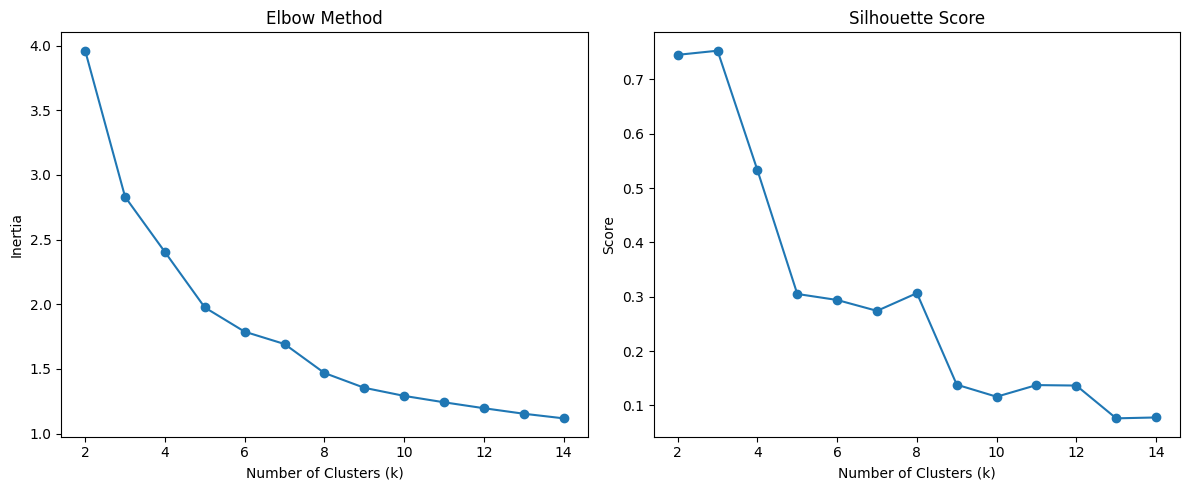

In [19]:
# 적당한 K값 찾기
X = return_df.T

# 적정 군집 수 찾기: Elbow & Silhouette
inertia = []
silhouette_scores = []
k_range = range(2, 15)ㅡ

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    cluster_labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# 시각화
plt.figure(figsize=(12, 5))

# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

클러스터별 평균 수익률:


date,2025-04-05 09:00:00,2025-04-06 09:00:00,2025-04-07 09:00:00,2025-04-08 09:00:00,2025-04-09 09:00:00,2025-04-10 09:00:00,2025-04-11 09:00:00,2025-04-12 09:00:00,2025-04-13 09:00:00
cluster,,,,,,,,,
0,0.003791,-0.022715,0.029078,0.036006,0.037481,-0.017417,-0.007576,0.027011,-0.013992
1,-0.001056,-0.060752,0.048273,-0.042364,0.421191,0.009097,-0.041840,-0.042290,-0.024975
2,-0.040111,-0.061716,0.017472,-0.101010,0.119850,-0.052174,0.643260,0.008804,-0.066198
3,0.015256,-0.084078,0.004953,-0.017085,0.098363,0.096505,-0.044750,0.015581,-0.009999
4,0.013933,0.730140,0.158850,0.264360,0.045947,0.589832,-0.020801,0.071338,0.044984
5,-0.006859,-0.101133,0.009318,-0.042268,0.094410,-0.023348,0.029546,0.042118,-0.014992


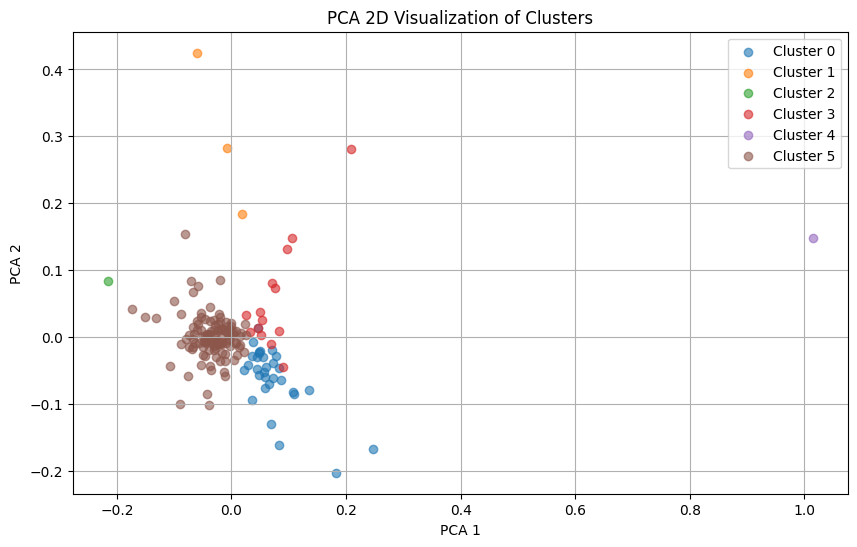

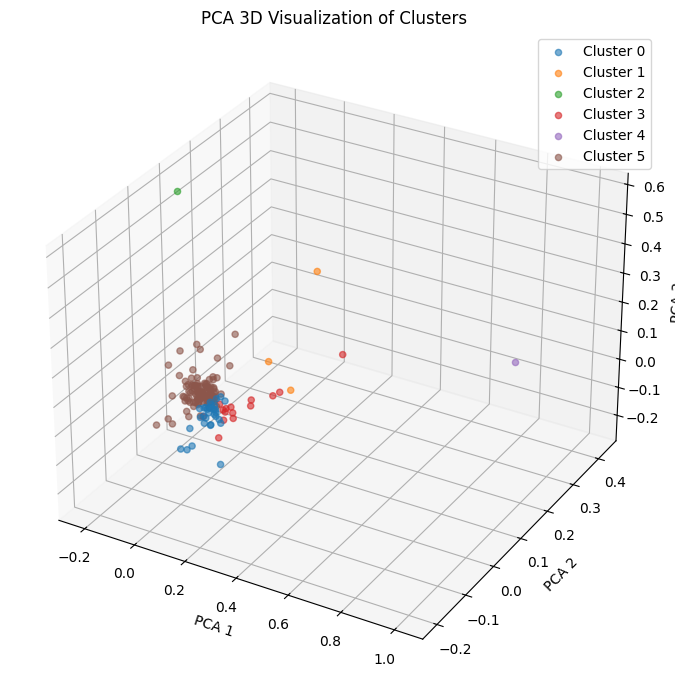

In [28]:
# KMeans 클러스터링 (k=6)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans_final = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X)

# PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

df_clustered = pd.DataFrame({
    'ticker': X.index,
    'cluster': cluster_labels,
    'pca_x': X_pca_2d[:, 0],
    'pca_y': X_pca_2d[:, 1],
    'pca_z': X_pca_3d[:, 2],
})
df_clustered.set_index('ticker', inplace=True)

# 📊 누적 수익률 계산
cumulative_returns = (return_df + 1).cumprod() - 1

# 📋 클러스터별 동일금액 투자 누적 수익률
ticker_cluster_map = df_clustered['cluster'].to_dict()

# 군집별 수익률 평균 계산
mean_returns_by_cluster = return_df.T.copy()
mean_returns_by_cluster['cluster'] = cluster_labels
cluster_summary = mean_returns_by_cluster.groupby('cluster').mean()

print("클러스터별 평균 수익률:")
display(cluster_summary)

# 2D 시각화
plt.figure(figsize=(10, 6))
for i in range(6):
    subset = df_clustered[df_clustered['cluster'] == i]
    plt.scatter(subset['pca_x'], subset['pca_y'], label=f'Cluster {i}', alpha=0.6)
plt.title('PCA 2D Visualization of Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

# 3D 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(6):
    subset = df_clustered[df_clustered['cluster'] == i]
    ax.scatter(subset['pca_x'], subset['pca_y'], subset['pca_z'], label=f'Cluster {i}', alpha=0.6)
ax.set_title('PCA 3D Visualization of Clusters')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()
plt.tight_layout()
plt.show()

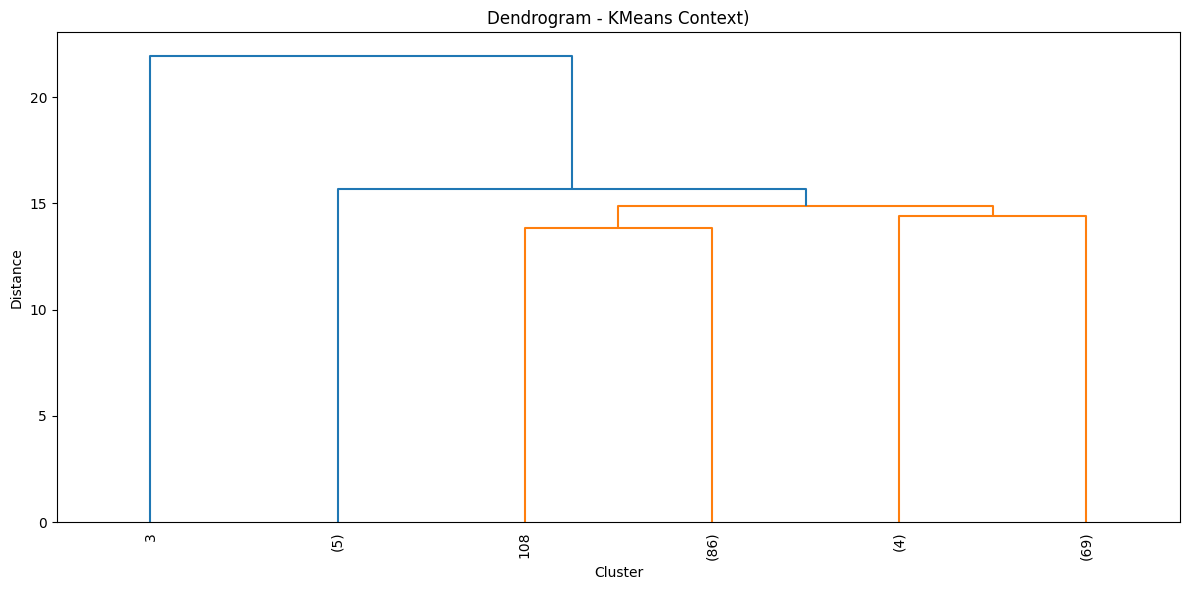

In [30]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked,
           truncate_mode='lastp',
           p=6,
           leaf_rotation=90.,
           leaf_font_size=10.)
plt.title("Dendrogram - KMeans Context)")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [31]:
# 클러스터 정보 불러오기
ticker_cluster_map = df_clustered['cluster'].to_dict()

# 클러스터별 종목 목록
cluster_ticker_map = {i: [] for i in range(6)}
for ticker, cluster_id in ticker_cluster_map.items():
    cluster_ticker_map[cluster_id].append(ticker)

# 클러스터별 동일 비중 투자 시 누적 수익률 계산
equal_investment_returns = pd.DataFrame(index=cumulative_returns.index)

for cluster_id, tickers in cluster_ticker_map.items():
    if len(tickers) > 0:
        equal_investment_returns[f'Cluster {cluster_id}'] = cumulative_returns[tickers].mean(axis=1)

# 전체 투자 기간의 일수 계산
num_days = len(equal_investment_returns)

# 마지막 시점 누적 수익률
final_returns = equal_investment_returns.iloc[-1]

# 연수익률 계산
annualized_returns = ((1 + final_returns) ** (252 / num_days)) - 1

# 결과 출력
annualized_df = annualized_returns.to_frame(name="Annualized Return")
print("클러스터별 동일금액 투자 연수익률:")
display(annualized_df)

클러스터별 동일금액 투자 연수익률:


,Annualized Return
Cluster 0,5.197803e+00
Cluster 1,1.457583e+02
Cluster 2,4.803862e+03
Cluster 3,4.660918e+00
Cluster 4,6.042145e+18
Cluster 5,-5.176143e-01


In [ ]:
---------------------------------------------------------------------------------------------------------------------------04. 16. 20:49 현재. 여기까지 수정 함

In [17]:
df_crypto_daily.groupby(by='cluster').cluster.count()

,cluster
cluster,
0,26284
1,64
2,137
3,24552
4,100
5,164


### 6. PCA

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

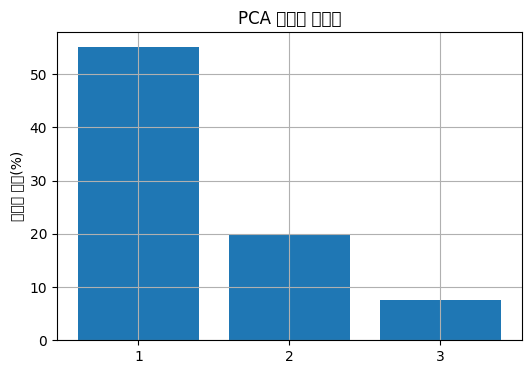

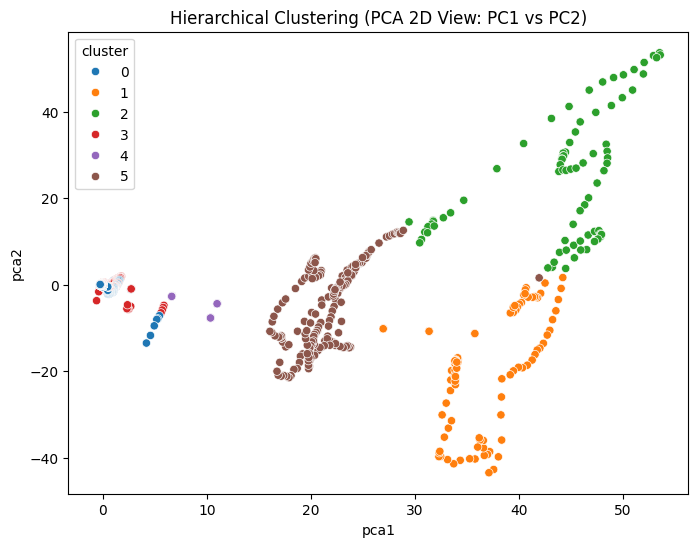

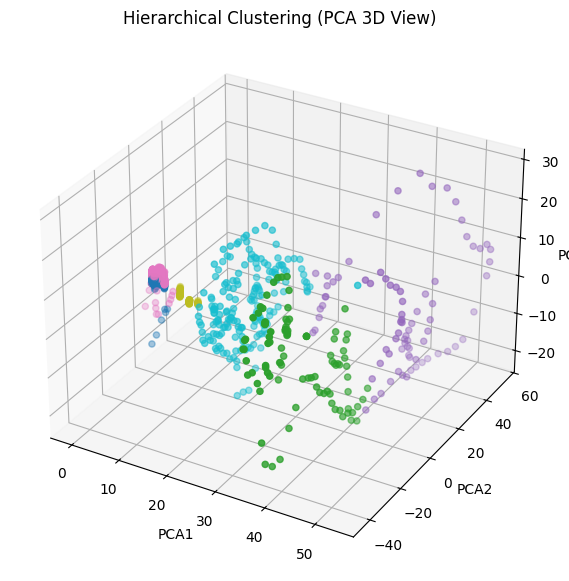

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

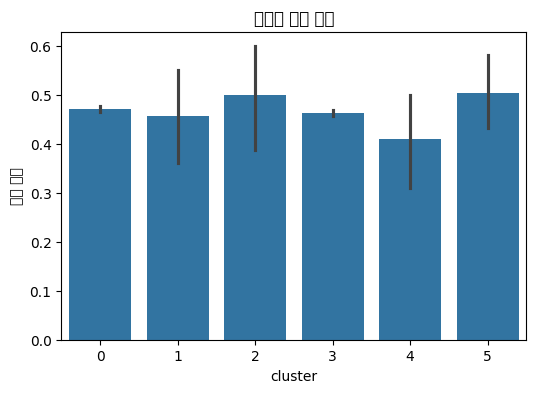

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
df_crypto_daily['pca1'] = X_pca[:, 0]
df_crypto_daily['pca2'] = X_pca[:, 1]
df_crypto_daily['pca3'] = X_pca[:, 2]

# 주성분 기여율 시각화
explained_var = pca.explained_variance_ratio_
plt.figure(figsize=(6, 4))
plt.bar(range(1, 4), explained_var * 100)
plt.xticks([1, 2, 3])
plt.ylabel("기여율 분산(%)")
plt.title("PCA 주성분 기여율")
plt.grid(True)
plt.show()

# 2D 시각화 (pca1 vs pca2)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_crypto_daily, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("Hierarchical Clustering (PCA 2D View: PC1 vs PC2)")
plt.show()

# 3D 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_crypto_daily['pca1'], df_crypto_daily['pca2'], df_crypto_daily['pca3'], c=df_crypto_daily['cluster'], cmap='tab10')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title("Hierarchical Clustering (PCA 3D View)")
plt.show()

# 군집별 상승 비율 시각화
plt.figure(figsize=(6, 4))
sns.barplot(data=df_crypto_daily, x='cluster', y='target', estimator=np.mean)
plt.ylabel("상승 비율")
plt.title("군집별 상승 비율")
plt.show()

### 7. 상승/하락 예측 모델 (RandomForest)


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.61      0.59      5482
           1       0.51      0.47      0.49      4749

    accuracy                           0.54     10231
   macro avg       0.54      0.54      0.54     10231
weighted avg       0.54      0.54      0.54     10231


Confusion Matrix:
 [[3319 2163]
 [2515 2234]]

ROC AUC Score: 0.5459910951893787


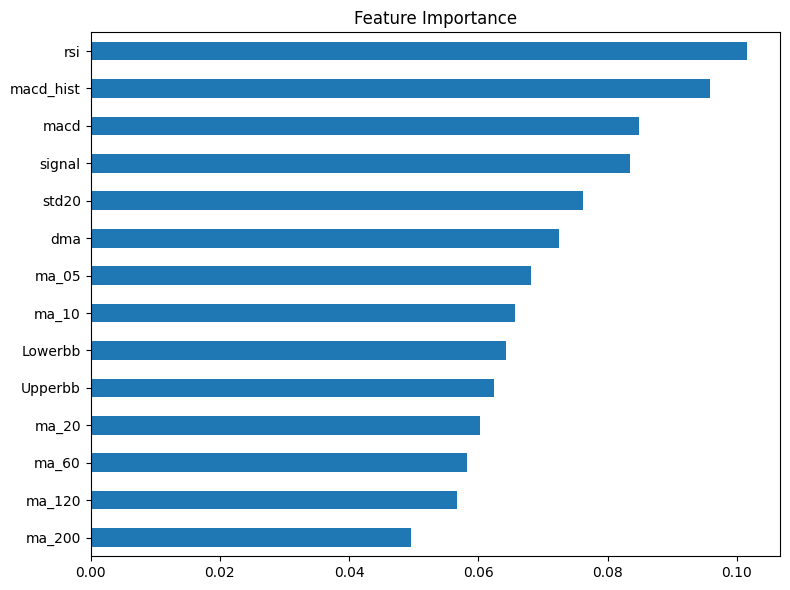

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

feat_importance = pd.Series(model.feature_importances_, index=feature_cols)
feat_importance.sort_values().plot(kind='barh', figsize=(8, 6), title="Feature Importance")
plt.tight_layout()
plt.show()

### 8. 군집별 백테스트

<Figure size 1000x500 with 0 Axes>

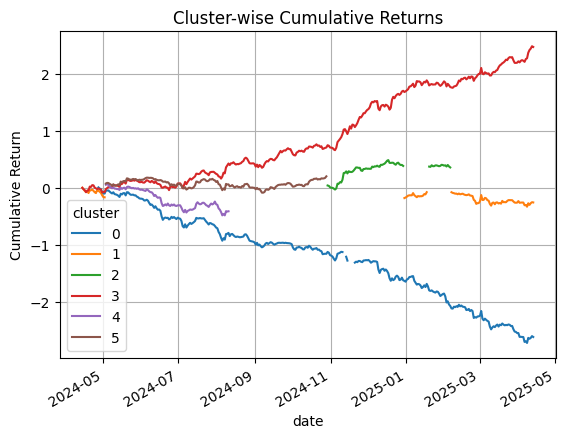

In [ ]:
backtest = df_crypto_daily.copy()
backtest['return'] = backtest.groupby('ticker')['close'].pct_change().fillna(0)
group_returns = backtest.groupby(['date', 'cluster'])['return'].mean().unstack()

plt.figure(figsize=(10, 5))
group_returns.cumsum().plot()
plt.title("Cluster-wise Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

### 9. LSTM 예측 모델

In [ ]:
# 종목 별로 다 돌려야 하는 관계로 BTC만 해 봄
ticker_sample = "KRW-BTC"
df_lstm = df_crypto_daily[df_crypto_daily['ticker'] == ticker_sample].copy()

sequence_length = 10
X_lstm, y_lstm = [], []

for i in range(len(df_lstm) - sequence_length):
    X_lstm.append(df_lstm[feature_cols].iloc[i:i+sequence_length].values)
    y_lstm.append(df_lstm['target'].iloc[i+sequence_length])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

model_lstm = Sequential([
    LSTM(64, input_shape=(sequence_length, len(feature_cols))),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, len(feature_cols))),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.fit(X_lstm, y_lstm, epochs=30, batch_size=16, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5084 - loss: 0.7010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5184 - loss: 0.6886
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5152 - loss: 0.6880
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5522 - loss: 0.6778
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5557 - loss: 0.6875
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5488 - loss: 0.6827
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5501 - loss: 0.6861
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5466 - loss: 0.6766
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5632 - loss: 0.6833
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5533 - loss: 0.6764
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5806 - loss: 0.6752
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy:

### 10. 결과 평가

#### 1) Random Forest 모델

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.61      0.59      5482
           1       0.51      0.47      0.49      4749

    accuracy                           0.54     10231
   macro avg       0.54      0.54      0.54     10231
weighted avg       0.54      0.54      0.54     10231


Confusion Matrix:
 [[3319 2163]
 [2515 2234]]

ROC AUC Score: 0.5459910951893787


### 11. 종목별 리포트

In [ ]:
report = df_crypto_daily.groupby('ticker').agg(
    total_days=('date', 'count'),
    avg_return=('target', 'mean'),
    cluster_mode=('cluster', lambda x: x.mode()[0] if not x.mode().empty else -1)
).reset_index()

print("\n[종목별 리포트]")
print(report)


[종목별 리포트]
        ticker  total_days  avg_return  cluster_mode
0    KRW-1INCH         365    0.490411             0
1     KRW-AAVE         365    0.484932             3
2      KRW-ADA         365    0.476712             3
3    KRW-AERGO         365    0.495890             3
4     KRW-AGLD         152    0.486842             0
..         ...         ...         ...           ...
161    KRW-XTZ         365    0.471233             0
162   KRW-ZETA         346    0.465318             0
163    KRW-ZIL         365    0.465753             0
164    KRW-ZRO         298    0.486577             3
165    KRW-ZRX         365    0.509589             0

[166 rows x 4 columns]
